## Predict pH optimum and range directly
- Previous I used the difference in activity as the loss funciton
- What if we just fit a normal distribution to each protein/experiment, and try to predict the mean (optimum) and standard deviation (range) directly?

20240411: Try many other ML methods

In [1]:
import numpy as np
import pandas as pd
import os
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/amondal2/.conda-envs/prot-eng/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [9]:
!pip install torch==2.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 14.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2


In [11]:
import torch
torch.cuda.is_available()

ImportError: libcudnn.so.9: cannot open shared object file: No such file or directory

In [4]:
torch.hub.set_dir('/projects/robustmicrob/amondal2/torch/')
model_name = "esm2_t33_650M_UR50D"
# model_name = "esm2_t36_3B_UR50D"
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)

NameError: name 'torch' is not defined

### Build/get embeddings

In [5]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file, index_col=0)
    sequences.set_index("Enzyme", inplace=True)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [6]:
inputs_dir = Path("/projects/robustmicrob/amondal2/invizyne/inputs/")
# Load the esm2 embeddings for these proteins
# they were built using the src/build_embeddings.py script
embeddings, df_seq = read_embeddings(inputs_dir / "embedding/embeddings_esm2_t33_650M_UR50D.npz",
                                     inputs_dir /"embedding/embeddings_seqs.csv")
print(embeddings.shape)

len(embeddings) = 138 read from /projects/robustmicrob/amondal2/invizyne/inputs/embedding/embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 138 read from /projects/robustmicrob/amondal2/invizyne/inputs/embedding/embeddings_seqs.csv
(138, 1280)


In [7]:
df_seq.head(2)

,Sequence
Enzyme,
D104I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
D104L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...


In [8]:
#df_seq = df_seq.reset_index()
#df_seq.head(2)

In [9]:
# I fit a normal curve to the pH range data for each protein/reaction type with 2+ activity points
# e.g., 50% activity at pH 6, 100% activity at pH 7, 80% activity at pH 8
# This file has all of those curves, as well as a single pH optimum point (fit_mean) for proteins where it's available 
data_file = Path("/projects/robustmicrob/amondal2/invizyne/inputs/20240917_AlsS.xlsx")
data_fits = pd.read_excel(data_file, sheet_name=0) 
print(len(data_fits), data_fits.Enzyme.nunique())
data_fits.head(2)

221 138


,Enzyme,Sequence,control,treated at 60C,% retained
0,D104I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.164326,0.060564,0.368560
1,D104L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.171965,0.077058,0.448101


In [10]:
data_fits = data_fits.rename(columns={"% retained": "retained"})
data_fits.head(2)

,Enzyme,Sequence,control,treated at 60C,retained
0,D104I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.164326,0.060564,0.368560
1,D104L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.171965,0.077058,0.448101


In [11]:
data_fits.retained.describe()

count    221.000000
mean       0.443218
std        0.162594
min        0.109262
25%        0.342884
50%        0.419330
75%        0.510712
max        1.021936
Name: retained, dtype: float64

In [12]:
data_fits = data_fits.drop(columns=['control', 'treated at 60C'])

In [13]:
data_fits = data_fits.replace("?", np.nan)

In [14]:
# oxidoreductases can often perform both oxidation and reduction
# so I manually annotated them by the type of reaction
#data_fits.reaction_type.value_counts()

In [15]:
print(f"# proteins with activity range data: {data_fits.dropna(subset='retained').Enzyme.nunique()}")
#print(f"# proteins & reaction types with pH range data: {len(data_fits.dropna(subset='retained'))}")

# proteins with activity range data: 138


In [16]:
# Not all protein IDs matched a uniprot ID, so limit the proteins to those with an embedding
data_fits = data_fits[data_fits.Enzyme.isin(df_seq.index)]
print(data_fits.Enzyme.nunique(), len(data_fits))
# Make sure each row has a pH optimum
data_fits.dropna(subset=['retained'], how="any", inplace=True)
print(data_fits.Enzyme.nunique(), len(data_fits))

138 221
138 221


In [17]:
data_fits['Enzyme'].value_counts()
data_fits = data_fits.groupby(['Enzyme', 'Sequence'], as_index=False)['retained'].mean()
data_fits

,Enzyme,Sequence,retained
0,A375I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.371118
1,A375L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.447088
2,A375M,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.511820
3,A375T,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.594529
4,A375V,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.459290
...,...,...,...
133,Y508F,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.375689
134,Y508I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.230590
135,Y508L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.471797
136,Y508M,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.509550


In [18]:
data_fits = data_fits[data_fits.Enzyme.isin(df_seq.index)]
print(data_fits.Enzyme.nunique(), len(data_fits))
# Make sure each row has a pH optimum
data_fits.dropna(subset=['retained'], how="any", inplace=True)
print(data_fits.Enzyme.nunique(), len(data_fits))

138 138
138 138


In [19]:
df_seq

,Sequence
Enzyme,
D104I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
D104L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
D104T,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
D104V,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
W432S,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
...,...
T3S,MLSKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
V13I,MLTKATKEQKSLIKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
V13W,MLTKATKEQKSLWKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...


In [20]:
print(df_seq.columns)

Index(['Sequence'], dtype='object')


In [21]:
enz_to_seq = dict(zip(df_seq.index, df_seq.Sequence))
seq_to_enz = dict(zip(df_seq.Sequence, df_seq.index))


In [22]:
data_fits['Sequence'] = data_fits.Enzyme.apply(lambda x: enz_to_seq[x])

In [23]:
# some uniprot IDs map to the same amino acid sequence
df_seq_uniq = data_fits['Sequence'].drop_duplicates()
print(len(df_seq_uniq), data_fits.Enzyme.nunique())

136 138


In [24]:
data_fits['Sequence'].value_counts()

Sequence
MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFDALQDKGPEIIVARHEQNAAFMAQAVGRLTGKPGVVLVTSGPGASNLATGLLTANTEGDPVVALAGNVPRADRLKRTHQSLDNAALFQPITKYSVEVQDPDNIPEAVTNAFRIAEAGQAGAAFVSFPQDVVNEVTNTKNVRPVAPPKLGPAPDDAISAAIAKIQTAKLPVVLVGMKGGRPEAIKAIRKLLKKTQLPFVETYQAAGTLSRDLEDLYFGRIGLFRNQPGDLLLEQADVVLTIGYDPIEYDPKFWNINGDRTIIHLDEIPADIDHYYQPDLELIGDIPSTINHIAHDAVKVEFSEREQKILSDLKQYMHELEQVPADWKSDRAHPLEIVKELRNAVDDDVTVTCDIGSHAIWMARYFRSYEPLTLMISNGMQTLGVALPWAIGASLVKPGEKVVSVSGDGGFLFSAMELETAVRLKAPIVHIVWNDSTYDMVAFQQLKKYNRTSGVDFGNIDIVKYAESFGATGLRVESPDQLADVLRQGMNAEGPVIIDVPVDYSDNINLASDKLPKEFGELMKTKAL    3
MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFDALQDKGPEIIVARHEQNAAFMAQAVGRLTGKPGVVLVTSGPGASNLATGLLTANTEGDPVVALAGNVPRADRLKRTHQSLDNAALFQPITKYSVEVQDPDNIPEAVTNAFRIAEAGQAGAAFVSFPQDVVNEVTNTKNVRPVAPPKLGPAPDDAISAAIAKIQTAKLPVVLVGMKGGRPEAIKAIRKLLKKTQLPFVETYQAAGTLSRDLEDLYFGRIGLFRNQPGDLLLEQADVVLTIGYDPIEYDPKFWNINGDRTIIHLDEIPADIDHYYQPDLELIGDIPSTINHIAHDAVKVEFSEREQKILSDLKQYRHELEQVPADWKSDRAHPLEIVKELRNAVDDDVTVTCDIGSHAIWMARYFRSYEP

In [25]:
# Assume you want to find entries for a specific sequence, e.g., 'your_sequence_here'
specific_sequence = 'MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFDALQDKGPEIIVARHEQNAAFMAQAVGRLTGKPGVVLVTSGPGASNLATGLLTANTEGDPVVALAGNVPRADRLKRTHQSLDNAALFQPITKYSVEVQDPDNIPEAVTNAFRIAEAGQAGAAFVSFPQDVVNEVTNTKNVRPVAPPKLGPAPDDAISAAIAKIQTAKLPVVLVGMKGGRPEAIKAIRKLLKKTQLPFVETYQAAGTLSRDLEDLYFGRIGLFRNQPGDLLLEQADVVLTIGYDPIEYDPKFWNINGDRTIIHLDEIPADIDHYYQPDLELIGDIPSTINHIAHDAVKVEFSEREQKILSDLKQYMHELEQVPADWKSDRAHPLEIVKELRNAVDDDVTVTCDIGSHAIWMARYFRSYEPLTLMISNGMQTLGVALPWAIGASLVKPGEKVVSVSGDGGFLFSAMELETAVRLKAPIVHIVWNDSTYDMVAFQQLKKYNRTSGVDFGNIDIVKYAESFGATGLRVESPDQLADVLRQGMNAEGPVIIDVPVDYSDNINLASDKLPKEFGELMKTKAL'

# Filter the DataFrame to get all rows where the sequence matches
filtered_df = data_fits[data_fits['Sequence'] == specific_sequence]

# Get the corresponding enzyme names and retained values as lists
enzymes = filtered_df['Enzyme'].tolist()
retained_values = filtered_df['retained'].tolist()

# Print the results
print("Enzyme names:", enzymes)
print("Retained values:", retained_values)

Enzyme names: ['I26I', 'V13V', 'WT']
Retained values: [0.2115231093688565, 0.3461553316923982, 0.3088992847879127]


In [26]:

specific_sequence = 'MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFDALQDKGPEIIVARHEQNAAFMAQAVGRLTGKPGVVLVTSGPGASNLATGLLTANTEGDPVVALAGNVPRADRLKRTHQSLDNAALFQPITKYSVEVQDPDNIPEAVTNAFRIAEAGQAGAAFVSFPQDVVNEVTNTKNVRPVAPPKLGPAPDDAISAAIAKIQTAKLPVVLVGMKGGRPEAIKAIRKLLKKTQLPFVETYQAAGTLSRDLEDLYFGRIGLFRNQPGDLLLEQADVVLTIGYDPIEYDPKFWNINGDRTIIHLDEIPADIDHYYQPDLELIGDIPSTINHIAHDAVKVEFSEREQKILSDLKQYMHELEQVPADWKSDRAHPLEIVKELRNAVDDDVTVTCDIGSHAIWMARYFRSYEPLTLMISNGMQTLGVALPWAIGASLVKPGEKVVSVSGDGGFLFSAMELETAVRLKAPIVHIVWNDSTYDMVAFQQLKKYNRTSGVDFGNIDIVKYAESFGATGLRVESPDQLADVLRQGMNAEGPVIIDVPVDYSDNINLASDKLPKEFGELMKTKAL'
filtered_df = data_fits[data_fits['Sequence'] == specific_sequence]

# Step 2: Calculate the mean of the retained values
mean_retained = filtered_df['retained'].mean()

# Step 3: Create a new DataFrame row with the desired values
new_row = pd.DataFrame({
    'Enzyme': ['WT'],  # Enzyme name set to 'WT'
    'Sequence': [specific_sequence],  # The same sequence
    'retained': [mean_retained]  # Mean of the retained values
})

# Step 4: Remove the old duplicate rows from the original DataFrame
data_fits = data_fits[data_fits['Sequence'] != specific_sequence]

# Step 5: Append the new row with the mean retained value to the DataFrame
data_fits = pd.concat([data_fits, new_row], ignore_index=True)

# Check the result
print(len(data_fits))
print(data_fits.head())

136
  Enzyme                                           Sequence  retained
0  A375I  MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...  0.371118
1  A375L  MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...  0.447088
2  A375M  MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...  0.511820
3  A375T  MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...  0.594529
4  A375V  MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...  0.459290


In [27]:
wt_rows = data_fits[data_fits['Enzyme'] == 'WT']

# Display the filtered rows
print(wt_rows)

    Enzyme                                           Sequence  retained
135     WT  MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...  0.288859


In [28]:
df_seq_uniq.head(2)

0    MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
1    MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...
Name: Sequence, dtype: object

### Split into train/test

TODO Run more thorough evaluations
1. Random split holdout of all data
2. Random split holdout of proteins with pH range data to see if the pH optimum data improves the pH range predictions
3. 10-fold CV
4. Assign sequences to uniref50 clusters and holdout a subset of those clusters
    - More stringent evaluation to see how well the model can extrapolate to proteins with low sequence similarity to those in the training set

In [29]:
# just take a random split for now
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_seq_uniq.values, test_size=0.1)
train = set(train)
test = set(test)
print(len(train), len(test))

122 14


In [30]:
# # optionally run this instead to keep the same train and test set as previous run
# split_file = "results/20230914_ph_range/df_split.csv"
# df = pd.read_csv(split_file)
# test = df[df.set == "test"]
# print(len(test))
# test.head(2)
# # train = df_seq_uniq[~df_seq_uniq.uniprot_id.isin(df_test.uniprot_id)].set_index('uniprot_id')
# # test = df_seq_uniq[df_seq_uniq.uniprot_id.isin(df_test.uniprot_id)].set_index('uniprot_id')
# # print(len(train), len(test))

In [31]:
def train_test_split(seq):
    if isinstance(test, set):
        if seq in test:
            return "test"
    else:
        if seq in test.Sequence.values:
            return "test"
    return "train"

data_fits['split'] = data_fits.Sequence.apply(train_test_split)
df_split = data_fits[["Enzyme", "Sequence", "retained", "split"]].drop_duplicates()
df_split.head(2)

,Enzyme,Sequence,retained,split
0,A375I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.371118,train
1,A375L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.447088,train


### Choose the columns to use as features

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
# reaction type should be relabeled "redox_type"
# categ_cols = ['reaction_type']
# categ_cols = ['reaction_type', 'enzyme_type']
# categ_cols = ['reaction_type', 'enzyme_type', 'enzyme_type_sub']
#categ_cols = ['reaction_type', 'enzyme_type', 'enzyme_type_sub', 'acceptor']

In [34]:
# def get_one_hot_encoder(data_fits, categ_cols):
#     enc = OneHotEncoder(drop=[np.nan] * len(categ_cols))
#     enc.fit(data_fits[categ_cols])
#     return enc

# enc = get_one_hot_encoder(data_fits, categ_cols)

### Predict a normal distribution for each sequence
The loss will be the MAE of the points compared to the curve

In [35]:
df_split.split.value_counts()

split
train    122
test      14
Name: count, dtype: int64

In [36]:
# seq_idx = {seq: idx for idx, seq in df_seq.sequence.items
seq_idx = dict(zip(df_seq.Sequence, df_seq.reset_index().index))
# print(list(seq_idx.items())[:2])

In [37]:
df_train = data_fits[data_fits.split == "train"]
df_test = data_fits[data_fits.split == "test"]
df_train.head(2)

,Enzyme,Sequence,retained,split
0,A375I,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.371118,train
1,A375L,MLTKATKEQKSLVKNRGAELVVDCLINQGVTHVFGIPGAKIDAVFD...,0.447088,train


In [38]:
def get_embeddings_and_features(df, embeddings, seq_idx):
    # some of the sequences are repeated, so get their embeddings by index
    X_split = np.asarray([embeddings[seq_idx[seq]] for seq in df.Sequence.values])
    #encoded_features = enc.transform(df[categ_cols]).toarray()
    #X_split = np.hstack([X_split, encoded_features])
    y_split = df[['retained']].values
    return X_split, y_split

# combine the sequence embeddings with the one-hot encoding of additional features (e.g., enzyme type, reaction type)
X_train, y_train = get_embeddings_and_features(df_train, embeddings, seq_idx)
X_test, y_test = get_embeddings_and_features(df_test, embeddings, seq_idx)
print(X_train.shape, f"{len(df_train) / (len(df_train) + len(df_test)):0.2f}")
print(X_test.shape, f"{len(df_test) / (len(df_train) + len(df_test)):0.2f}")

(122, 1280) 0.90
(14, 1280) 0.10


In [39]:
X_test.shape

(14, 1280)

In [40]:
# max and min pH optimum
print(y_train[:,0].max(), y_train[:,0].min())
print(y_test[:,0].max(), y_test[:,0].min())

0.9123750228314128 0.10926165791505646
0.7027809324927239 0.24707705974357758


In [41]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [42]:
class neural_network_fits(pl.LightningModule):
    def __init__(self, initial_layer_size=1280, lr=1e-3):
        """ Given an input esm2 sequence embedding, 
        predicts the retained activity.
        """
        super(neural_network_fits, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.LeakyReLU(),            
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),
        )
        self.lr = lr
        # l1 loss reduction
        self.reduction = "mean"

    def forward(self, x):
        # predict the mean and std deviation
        logits = self.linear_relu_stack(x)
        # return logits
        # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]

        # take the sigmoid of the pH mean logits, then multiply by 13 to get in the range 0-13
        y_pred = torch.sigmoid(logits[:,0])
        #y_pred_mean = torch.multiply(y_pred_mean, 13)
        # limit the standard deviation to between 0 and 4.25
        #y_pred_sigma = torch.sigmoid(logits[:,1])
        #y_pred_sigma = torch.multiply(y_pred_sigma, 4.25)
        return y_pred
#         return dist, y_pred_mean, y_pred_sigma

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_true = y[:,0]
        
        # logits = self(x)
        # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
        y_pred = self(x)

        # use mse_loss or l1_loss (mae) on both the ph opt
        loss = nn.functional.l1_loss(y_pred, y_true, reduction=self.reduction)
        # and the ph standard deviation. Only use rows that are not nan
        #loss += nn.functional.l1_loss(y_pred_sigma[~torch.isnan(y_std)], 
         #                             y_std[~torch.isnan(y_std)],
         #                             reduction=self.reduction)
        self.log('train_loss', loss)
        return loss
    
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_ph, y_act = y[:,0], y[:,1]
        
#         y_pred = self(x)
#         y_pred_mean, y_pred_sigma = y_pred[:,0], y[:,1]
#         y_pred_act = self.get_gaus_pred(y_ph, y_pred_mean, y_pred_sigma)

#         loss = nn.functional.l1_loss(y_pred_act, y_act)
#         self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [43]:
def fit_model(X_train, y_train, X_valid, epochs=20, lr=1e-3):
    pl.seed_everything(42)
    model = neural_network_fits(initial_layer_size=X_train.shape[1], 
                                lr=lr,
                               )
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=epochs,
        check_val_every_n_epoch=5)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model, trainer

In [44]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [177]:
# For debugging, just look at 10 rows
# X_train_2 = X_train[:10,:]
# y_train_2 = y_train[:10,:]
# X_test_2 = X_test[:10,:]
# head_model_2 = fit_model(X_train_2, y_train_2, X_test_2, epochs=20)

In [45]:
def eval_model(head_model, X_test, y_test, to_print=""):
    # logits = head_model(torch.Tensor(X_test)).detach().numpy()
    # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
    y_pred = head_model(torch.Tensor(X_test))
    y_pred= y_pred.detach().numpy()
    y_true = y_test[:,0]
    df_err = pd.DataFrame({"activity retained": y_true, "NN activity retained": y_pred})
    #y_pred_sigma = y_pred_sigma[~np.isnan(y_std)]
    #y_std = y_std[~np.isnan(y_std)]

    # now calculate the overall MAE
    # build a df instead of printing?
    # df_err = []
    print("split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2")
    #for y_true, y_pred, name in zip([y_opt, y_std], [y_pred_mean, y_pred_sigma], ["pH opt", "pH std"]):
    rho, _ = spearmanr(y_pred, y_true)  # spearman
    r2, _ = pearsonr(y_pred, y_true)  # spearman
    mse = mean_squared_error(y_pred, y_true)  # Mean Squared Error
    mae = np.mean(np.abs(y_pred - y_true))  # Mean Absolute Error
    print(f"{to_print}{'Retained %'}, {mae:0.2f}, {mse:0.2f}, {rho:0.2f}, {r2:0.2f}")
        
    return y_pred, df_err

In [46]:
X_test.shape

(14, 1280)

In [50]:
# TODO run a full hyperparameter optimization
epochs = 30000
lr = 1e-4
# the model performs better with more of these features, 
# but they are not always available
#categ_col_sets = [
    # ['reaction_type'],
    # ['reaction_type', 'enzyme_type'],
    # ['reaction_type', 'enzyme_type', 'enzyme_type_sub'],
    #['reaction_type', 'enzyme_type', 'enzyme_type_sub', 'acceptor'],
#]
#for categ_cols in categ_col_sets:
  #  enc = get_one_hot_encoder(data_fits, categ_cols)
  #  X_train, y_train = get_embeddings_and_features(df_train, embeddings, seq_idx, enc, categ_cols)
   # X_test, y_test = get_embeddings_and_features(df_test, embeddings, seq_idx, enc, categ_cols)
# for batch_size in 
head_model, trainer = fit_model(X_train, y_train, X_test, epochs=epochs, lr=lr)
eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}")
eval_model(head_model, X_train, y_train, f"train, {epochs}, {lr}")

Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/amondal2/.conda-envs/prot-eng/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/amondal2/.conda-envs/prot-eng/lib/python3.10/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K 
-----------------

Epoch 29999: 100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 210.29it/s, v_num=11]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 29999: 100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 193.87it/s, v_num=11]
split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
test, 30000, 0.0001Retained %, 0.14, 0.04, -0.32, -0.57
split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
train, 30000, 0.0001Retained %, 0.02, 0.00, 0.97, 0.96


(array([0.4048073 , 0.48052645, 0.5918584 , 0.48889968, 0.7252702 ,
        0.6578152 , 0.56938446, 0.62585914, 0.31349474, 0.36940506,
        0.5363071 , 0.48630458, 0.41502112, 0.4483537 , 0.3578903 ,
        0.38575947, 0.556525  , 0.4081842 , 0.3220808 , 0.6081343 ,
        0.37349746, 0.51208186, 0.4136129 , 0.3611438 , 0.22658508,
        0.368486  , 0.6514426 , 0.5003318 , 0.4448905 , 0.7746968 ,
        0.50337476, 0.39870787, 0.32901555, 0.5184725 , 0.33669117,
        0.35198146, 0.56026834, 0.5002501 , 0.3607296 , 0.39681977,
        0.7422639 , 0.6705812 , 0.5619385 , 0.36051095, 0.34001496,
        0.2530181 , 0.49997824, 0.3000775 , 0.3321474 , 0.34933895,
        0.34351555, 0.34125397, 0.4289177 , 0.6285019 , 0.43814096,
        0.38772875, 0.5139096 , 0.47561926, 0.2656313 , 0.30280867,
        0.36249748, 0.45031625, 0.39157164, 0.37603104, 0.5913257 ,
        0.37089723, 0.61580735, 0.6279015 , 0.34982508, 0.60708815,
        0.36697495, 0.37106484, 0.34787953, 0.64

In [51]:
y_pred, df_err = eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr},")

split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
test, 30000, 0.0001,Retained %, 0.14, 0.04, -0.32, -0.57


In [200]:
y_pred, df_err = eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr},")

split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
test, 10000, 0.0001,Retained %, 0.11, 0.01, 0.09, 0.21


In [222]:
df_err

,activity retained,ML activity retained
0,0.371118,0.467243
1,0.550919,0.349739
2,0.409293,0.344031
3,0.333290,0.490481
4,0.360944,0.401520
5,0.360415,0.586687
6,0.331707,0.437552
7,0.518494,0.465632
8,0.582515,0.532350
9,0.360495,0.502297


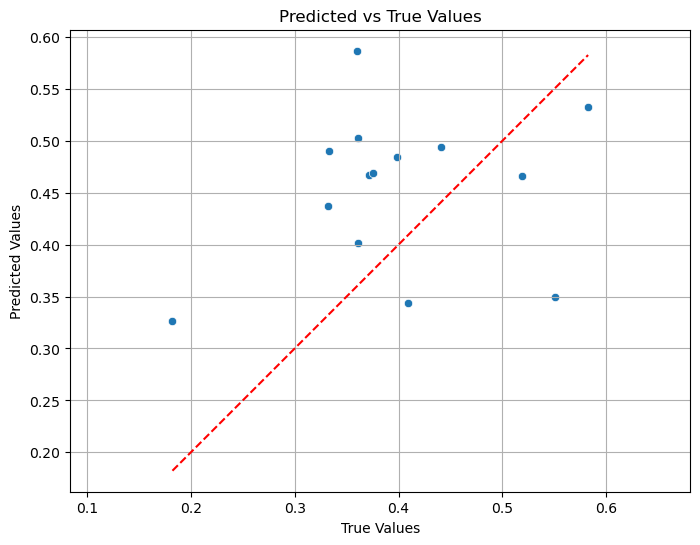

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns



# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test[:,0], y=y_pred)

# Add a line for perfect prediction
plt.plot([min(y_test[:,0]), max(y_test[:,0])], [min(y_test[:,0]), max(y_test[:,0])], color='red', linestyle='--')

# Set labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.axis('equal')  # Ensure equal scaling
plt.grid()
plt.show()


### Build neural net on sequence embeddings

TODO Try out different approaches to make predictions. Checkout the [UniKP](https://doi.org/10.1038/s41467-023-44113-1) paper for a good example
- Linear Regression, Ridge Regression
- Decision Tree, Random Forest, Gradient Boosting, AdaBoost
- Extra Trees (Performed the best)
- LGBM
- Feed forward neural network (implemented here)
- CNN, RNN

In [219]:
def run_simple_pred(model, X_train, y_train, X_test, y_test):
    # split into ph opt and ph range data
    #train_pho, train_phr = y_train[:,0], y_train[:,1]
    #test_pho, test_phr = y_test[:,0], y_test[:,1]
    # limit ph range to non-nan values
    y_train = y_train[:,0][~np.isnan(y_train[:,0])]
    y_test = y_test[:,0][~np.isnan(y_test[:,0])]

    model_act = model().fit(X_train, y_train)
    #train_phr_idx = np.argwhere(~np.isnan(y_train[:,1])).flatten()
    #model_phr = model().fit(X_train[train_phr_idx,:], train_phr)

    pred_retained = model_act.predict(X_test)
    #pred_phr = model_phr.predict(X_test)
    
    # combine the predictions back into a single vector(?)
    # no need to subset predictions to originally non-nan
    #y_pred = np.array(shape=y_test)
    # y_pred[np.argwhere(~np.isnan(y_test[:,1])),1] = pred_phr
    return pred_retained

In [220]:
# run simple predictors first
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

df_pred = pd.DataFrame()
for name, method in [("LR", LinearRegression), 
                     ("RR", Ridge),
                     ("KR", KernelRidge),
                     ("DTree",DecisionTreeRegressor),
                     ("RForest", RandomForestRegressor),
                     ("ExtraTrees", ExtraTreesRegressor),
                     ("GradientBoost", GradientBoostingRegressor),
                     ("AdaBoost", AdaBoostRegressor),
                    ]:
    print(name, method)
    pred_retained = run_simple_pred(method, X_train, y_train, X_test, y_test)
    df_pred[f"{name}_retained"] = pred_retained
    #df_pred[f"{name}_phr"] = pred_phr
df_pred

LR <class 'sklearn.linear_model._base.LinearRegression'>
RR <class 'sklearn.linear_model._ridge.Ridge'>
KR <class 'sklearn.kernel_ridge.KernelRidge'>
DTree <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RForest <class 'sklearn.ensemble._forest.RandomForestRegressor'>
ExtraTrees <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
GradientBoost <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
AdaBoost <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>


,LR_retained,RR_retained,KR_retained,DTree_retained,RForest_retained,ExtraTrees_retained,GradientBoost_retained,AdaBoost_retained
0,0.429688,0.438591,0.438201,0.388736,0.456574,0.466182,0.458730,0.460677
1,0.347656,0.437759,0.437259,0.352239,0.416073,0.427781,0.415256,0.405586
2,0.105469,0.437753,0.437275,0.507368,0.356533,0.371524,0.304394,0.375216
3,0.484375,0.438984,0.438775,0.630851,0.480841,0.479806,0.472900,0.485412
4,0.207031,0.439047,0.438909,0.419126,0.390861,0.383222,0.440056,0.451324
5,0.554688,0.440331,0.440684,0.725413,0.507374,0.528982,0.621894,0.599931
6,0.425781,0.439377,0.439402,0.299354,0.439017,0.447888,0.491369,0.453851
7,0.332031,0.437424,0.436744,0.178734,0.401759,0.399265,0.470081,0.451324
8,0.613281,0.438765,0.438705,0.434885,0.484327,0.505907,0.518641,0.453775
9,0.339844,0.438682,0.438515,0.388731,0.466795,0.447078,0.469728,0.465258


In [228]:
df_err = df_err.rename(columns={"NN activity retained": "NN_retained"})
df_pred_all = pd.concat([df_err, df_pred], axis=1)
df_pred_all

,activity retained,NN_retained,LR_retained,RR_retained,KR_retained,DTree_retained,RForest_retained,ExtraTrees_retained,GradientBoost_retained,AdaBoost_retained
0,0.371118,0.467243,0.429688,0.438591,0.438201,0.388736,0.456574,0.466182,0.458730,0.460677
1,0.550919,0.349739,0.347656,0.437759,0.437259,0.352239,0.416073,0.427781,0.415256,0.405586
2,0.409293,0.344031,0.105469,0.437753,0.437275,0.507368,0.356533,0.371524,0.304394,0.375216
3,0.333290,0.490481,0.484375,0.438984,0.438775,0.630851,0.480841,0.479806,0.472900,0.485412
4,0.360944,0.401520,0.207031,0.439047,0.438909,0.419126,0.390861,0.383222,0.440056,0.451324
5,0.360415,0.586687,0.554688,0.440331,0.440684,0.725413,0.507374,0.528982,0.621894,0.599931
6,0.331707,0.437552,0.425781,0.439377,0.439402,0.299354,0.439017,0.447888,0.491369,0.453851
7,0.518494,0.465632,0.332031,0.437424,0.436744,0.178734,0.401759,0.399265,0.470081,0.451324
8,0.582515,0.532350,0.613281,0.438765,0.438705,0.434885,0.484327,0.505907,0.518641,0.453775
9,0.360495,0.502297,0.339844,0.438682,0.438515,0.388731,0.466795,0.447078,0.469728,0.465258


In [235]:
method_list = ["NN", "LR", "RR", "KR", 
               "DTree","RForest", "ExtraTrees", 
               "GradientBoost", "AdaBoost"
              ]
# df_err_all = pd.DataFrame()
results = []
for name in method_list:
    #for col, pred_col in zip(["pH opt",], [f"{name}_retained", f"{name}_phr"]):
    y_pred = df_pred_all[name+"_retained"]
    y_true = df_pred_all["activity retained"]
    r2, _ = pearsonr(y_pred, y_true)  # pearsonr
    rho, _ = spearmanr(y_pred, y_true)  # spearman
    mse = mean_squared_error(y_pred, y_true)  # Mean Squared Error
    mae = np.mean(np.abs(y_pred - y_true))# Mean Absolute Error
    results += [[name,  mae, mse, rho, r2]]
results

[['NN',
  0.10819935655396694,
  0.014859491140527318,
  0.0945054945054945,
  0.21291038624988132],
 ['LR',
  0.14758688136748987,
  0.028314946375645265,
  0.12087912087912088,
  0.19726824267151163],
 ['RR',
  0.08900064167563393,
  0.011288052075017322,
  -0.4021978021978022,
  -0.32161718636265235],
 ['KR',
  0.0890066000412572,
  0.011291955167670842,
  -0.3802197802197802,
  -0.3396410168322777],
 ['DTree',
  0.15105785523600743,
  0.03826349319201362,
  -0.3494505494505495,
  -0.38076714688273994],
 ['RForest',
  0.10354771509988156,
  0.01388511498656192,
  -0.16483516483516483,
  -0.04687101524958938],
 ['ExtraTrees',
  0.10237145103687935,
  0.013151906071711308,
  0.03736263736263736,
  0.15360395289207057],
 ['GradientBoost',
  0.10503928732357617,
  0.01424986194824085,
  -0.07252747252747253,
  0.2757915543719173],
 ['AdaBoost',
  0.1102291650093602,
  0.015356058896462448,
  -0.28445580077846633,
  0.026783431847625848]]

In [238]:
df_stats = pd.DataFrame(results, columns=["method", "MAE", "MSE", "rho", "R2"])
df_stats

,method,MAE,MSE,rho,R2
0,NN,0.108199,0.014859,0.094505,0.212910
1,LR,0.147587,0.028315,0.120879,0.197268
2,RR,0.089001,0.011288,-0.402198,-0.321617
3,KR,0.089007,0.011292,-0.380220,-0.339641
4,DTree,0.151058,0.038263,-0.349451,-0.380767
5,RForest,0.103548,0.013885,-0.164835,-0.046871
6,ExtraTrees,0.102371,0.013152,0.037363,0.153604
7,GradientBoost,0.105039,0.014250,-0.072527,0.275792
8,AdaBoost,0.110229,0.015356,-0.284456,0.026783


<Axes: xlabel='R2', ylabel='method'>

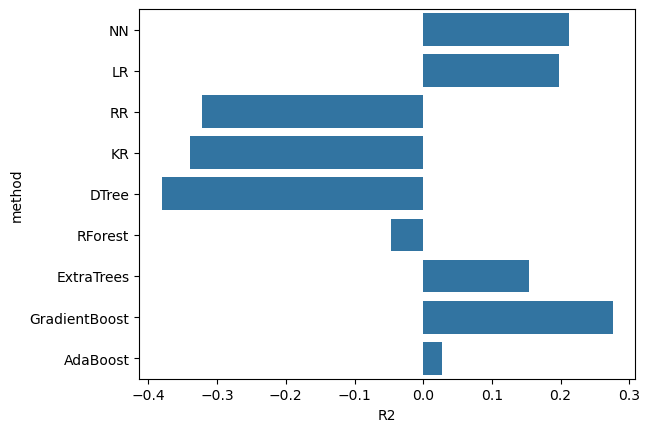

In [241]:
sns.barplot(data=df_stats, y="method", x="R2")

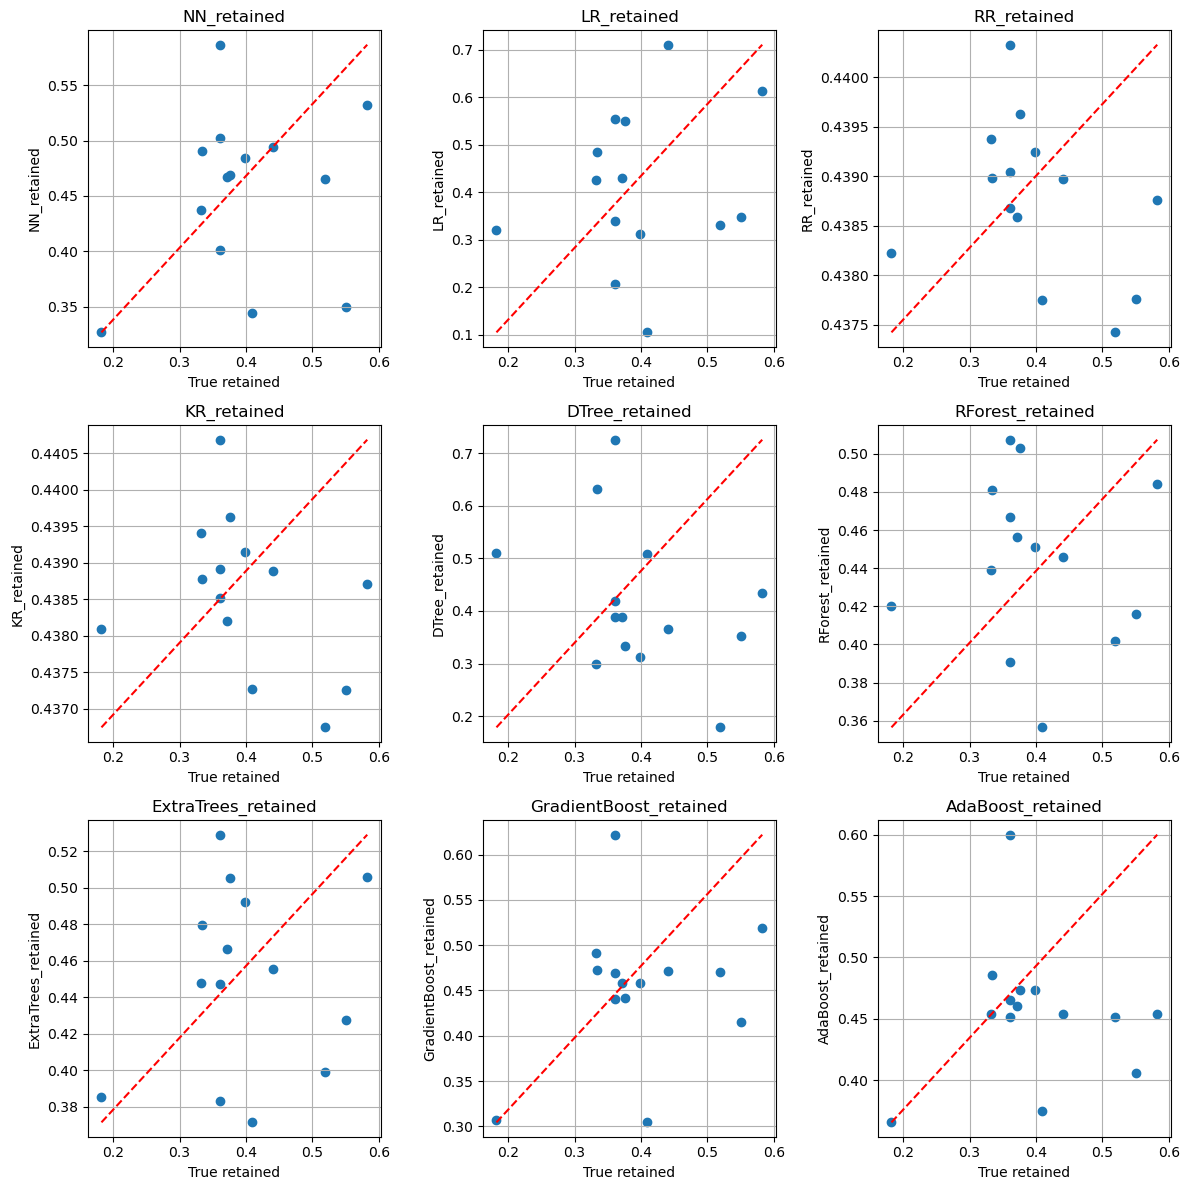

In [252]:
num_cols = len(df_pred_all.columns) - 1  # Exclude the first column for x-axis
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
# Plot each column against the first column
for i, column in enumerate(df_pred_all.columns[1:]):  # Skip the first column
    axes[i].scatter(df_pred_all['activity retained'], df_pred_all[column], marker='o', linestyle='-')
    axes[i].plot([min(df_pred_all['activity retained']), max(df_pred_all['activity retained'])], [min(df_pred_all[column]), max(df_pred_all[column])], color='red', linestyle='--')
    axes[i].set_title(column)
    axes[i].set_xlabel('True retained')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## Previous results

In [ ]:
for epochs in [50]:
    for lr in [1e-3, 1e-4]:
    # for lr in [1e-4]:
        # for batch_size in 
        head_model, trainer = fit_model(X_train, y_train, X_test, epochs=epochs, lr=lr)
        eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")
        eval_model(head_model, X_train, y_train, f"train, {epochs}, {lr}, ")

In [48]:
y_pred_mean, y_pred_sigma, df_err = eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")

split, epochs, lr, features, MAE, MSE, spearman rho, pearson r2
test, 50, 0.0001, pH opt, 0.75, 1.06, 0.65, 0.70
test, 50, 0.0001, pH std, 0.55, 0.62, 0.22, 0.20


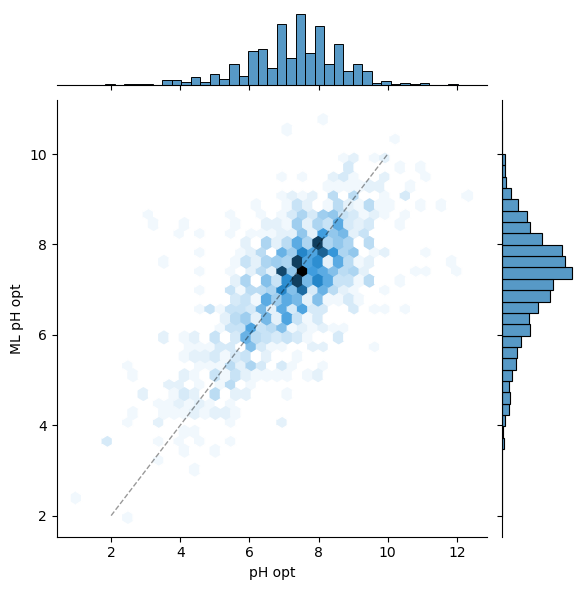

In [50]:
g = sns.jointplot(df_err, x="pH opt", y="ML pH opt", 
              # alpha=0.3, s=5, linewidth=0, 
                  kind="hex"
             )
g.ax_joint.plot([2,10], [2,10], ls='--', alpha=0.4, color="black", linewidth=1)

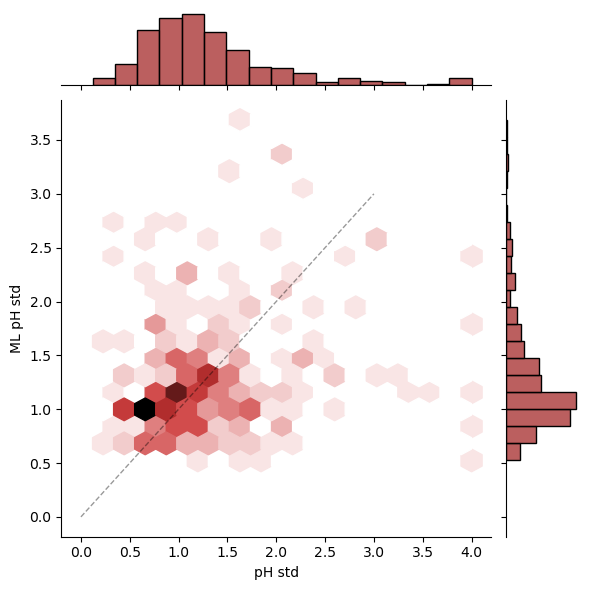

In [52]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              # alpha=0.4, s=20, linewidth=0, 
                  kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.4, color="black", linewidth=1)

TODO: investigate the outliers. May be a data quality issue

Text(0.5, 1.0, 'pH ')

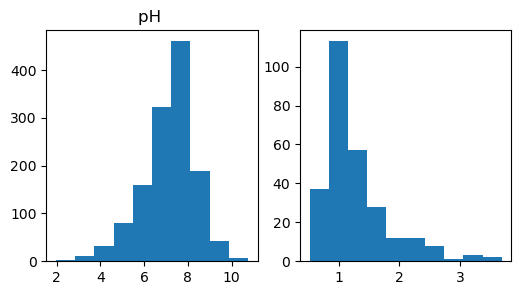

In [53]:
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(6,3))
ax.hist(y_pred_mean)
ax2.hist(y_pred_sigma)
ax.set_title("pH opt")
ax.set_title("pH ")

Use the ph_range test set to see if the extra ph_opt data is helping

### Show plots for individual prots
Check ph range predictions for some individual proteins. 

2024-03-12: need to load the original data points to compare with the curve fits and predicted curve fits

In [67]:
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [69]:
# define the gaussian function
def gaus(x,c,x_mean,sigma):
    return c*np.exp(-(x-x_mean)**2/(2*sigma**2))

In [62]:
def get_ez_type(row):
    if row.oxidation == 1:
        return 'oxidation'
    elif row.reduction == 1:
        return 'reduction'

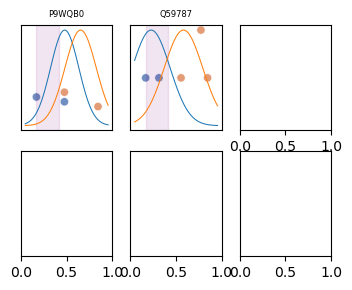

In [71]:
def plot_indv_prot_curves(df_test, y_pred_mean, y_pred_sigma, nrows=8, ncols=4):
    # get the predicted activity over all ph values
    all_ph_vals = np.arange(1, 13.5, 0.1)

    f, axes = plt.subplots(ncols=ncols, nrows=nrows, 
                           figsize=(nrows*2,ncols), 
                           sharey=True, sharex=False)
    axes_list = [ax for ax_row in axes for ax in ax_row]
    # cols = ["uniprot_id", "enzyme_type", "enzyme_type_sub", "acceptor"]
    i = -1
    df_redox = df_test[(df_test.oxidation == 1) |
                       (df_test.reduction == 1)]
    for (uniprot_id, df_u) in df_redox.groupby("uniprot_id"):
        df_u['enzyme_type'] = df_u.apply(get_ez_type, axis=1)
        df_u = df_u[df_u.enzyme_type.isin(["oxidation", "reduction"])]
        if len(df_u) <= 1:
            continue
        e_types = df_u.enzyme_type.unique()
        if 'oxidation' not in e_types or 'reduction' not in e_types:
            continue
        i += 1
        df_pred_act_u = []
        for (e_type, df_cat) in df_u.groupby('enzyme_type'):
            pred_mean_u = y_pred_mean[df_cat.index[0]].detach().numpy()
            pred_sigma_u = y_pred_sigma[df_cat.index[0]].detach().numpy()
            # print(uniprot_id, e_type, pred_mean_u, pred_sigma_u)
            pred_act = gaus(all_ph_vals, 1, pred_mean_u, pred_sigma_u)
            # limit the predicted activity to min_ph -1 and max_ph +1
            df_pred_act_u_cat = pd.DataFrame({'ph': all_ph_vals, 'activity': pred_act})
            df_pred_act_u_cat['enzyme_type'] = e_type
            ph_min = min(df_u.ph.min() - 1, 5.5)
            ph_max = max(df_u.ph.max() + 1, 8.5)
            df_pred_act_u_cat = df_pred_act_u_cat[(df_pred_act_u_cat.ph >= ph_min) & 
                                                  (df_pred_act_u_cat.ph <= ph_max)]
            df_pred_act_u += [df_pred_act_u_cat]
            # print(e_type, df_pred_act_u_cat[['ph', 'activity']].max())
        df_pred_act_u = pd.concat(df_pred_act_u)

        if i >= len(axes_list):
            break
        ax = axes_list[i]
        ax.set_title(uniprot_id, fontsize=6)
        sns.lineplot(x='ph', y='activity', data=df_pred_act_u, ax=ax,
                     # palette='deep', 
                     hue='enzyme_type', hue_order=['reduction', 'oxidation'],
                     size=1, 
                     legend=None)
        sns.scatterplot(x='ph', y='activity', data=df_u, ax=ax,
                        hue='enzyme_type', hue_order=['reduction', 'oxidation'],
                        palette='deep',
                        alpha=0.8,
                        legend=None
                       )
        ax.set_ylabel("")
        ax.set_xlabel("")
        # hide ax labels
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        # hide ax ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # add a vertical bar at ph=6--8
        ax.axvspan(6, 8, alpha=0.1, color='purple')
        # ax.set_xlabel
        # L = ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

    plt.show()
    plt.close()
    
plot_indv_prot_curves(df_test, y_pred_mean, y_pred_sigma,
                      nrows=2, ncols=3)

In [121]:
out_dir = Path("results/20231026_ph_opt_and_range")

In [122]:
# if __name__ == "__main__":
out_file = out_dir / f"20231011_ph_range_{model_name}.pt"
print(out_file)
torch.save(head_model, out_file)

results/20231026_ph_opt_and_range/20231011_ph_range_esm2_t33_650M_UR50D.pt


## Evaluate E. coli
Leave out all the E. coli proteins as the test set.

2024-03-12: need to re-run this analysis

In [74]:
uniprot_seq_info_file = Path("inputs/ph_merged/idmapping_2023_10_19.tsv.gz")
seq_info = pd.read_table(uniprot_seq_info_file)
seq_info = seq_info.rename(columns={"From": "uniprot_id"})
print(len(seq_info))
seq_info = seq_info.dropna(subset="Organism")
print(len(seq_info))
seq_info.head(2)

12926
12896


,uniprot_id,Entry,Reviewed,Protein names,Gene Names,Organism,Organism (ID),Length,pH dependence,Kinetics,...,Temperature dependence,EC number,Catalytic activity,Cofactor,Activity regulation,Binding site,Active site,Site,Pathway,Absorption
0,A0A023I760,A0A023I760,unreviewed,Sigma class glutathione S-transferase,NaN,Hyriopsis cumingii (Triangle sail mussel) (Uni...,165450.0,203.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A023I7E1,A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,4839.0,796.0,BIOPHYSICOCHEMICAL PROPERTIES: pH dependence:...,NaN,...,BIOPHYSICOCHEMICAL PROPERTIES: Temperature de...,3.2.1.39,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,NaN,ACTIVITY REGULATION: Tris binds the active sit...,"BINDING 504; /ligand=""(1,3-beta-D-glucosyl)n"";...","ACT_SITE 500; /evidence=""ECO:0000255|PROSITE-P...",NaN,NaN,NaN


In [71]:
seq_info.Organism.value_counts()

Homo sapiens (Human)                                                                      713
Arabidopsis thaliana (Mouse-ear cress)                                                    514
Escherichia coli (strain K12)                                                             472
Rattus norvegicus (Rat)                                                                   385
Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast)                     329
                                                                                         ... 
Cryptomeria japonica (Japanese cedar) (Cupressus japonica)                                  1
Vargula hilgendorfii (Sea firefly) (Cypridina hilgendorfii)                                 1
Thermoanaerobacter thermohydrosulfuricus (Clostridium thermohydrosulfuricum)                1
Leishmania chagasi                                                                          1
Gaeumannomyces graminis (Turf grass take-all root rot fungus

In [77]:
ecoli_rows = seq_info[seq_info.Organism.apply(lambda x: "Escherichia coli" in x)]
print(len(ecoli_rows))

545


In [91]:
ecoli_prots = set(ecoli_rows.uniprot_id.values)
len(ecoli_prots)

545

In [73]:
data_fits.head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,enzyme_type,enzyme_type_sub,acceptor,sequence,oxidation,reduction,split
2,A0A023I760,NaN,8.0,NaN,Transferases,"alkyl or aryl groups, other than methyl groups",NaN,MRTYRLTYSDIRGRAELARLVFVAAGESFEDRRVSREEWAELKKET...,0,0,train
3,A0A023I7E1,NaN,5.5,NaN,Hydrolases,Glycosylases,NaN,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,0,0,train


In [94]:
def ecoli_holdout(u_id):
    if u_id in ecoli_rows.uniprot_id:
        return "test"
    else:
        return "train"
data_fits["split"] = "train"
data_fits.loc[data_fits.uniprot_id.isin(ecoli_prots), "split"] = "test"
data_fits.split.value_counts()

train    12506
test       558
Name: split, dtype: int64

In [95]:
df_train = data_fits[data_fits.split == "train"]
df_test = data_fits[data_fits.split == "test"]
df_train.head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,enzyme_type,enzyme_type_sub,acceptor,sequence,oxidation,reduction,split
2,A0A023I760,NaN,8.0,NaN,Transferases,"alkyl or aryl groups, other than methyl groups",NaN,MRTYRLTYSDIRGRAELARLVFVAAGESFEDRRVSREEWAELKKET...,0,0,train
3,A0A023I7E1,NaN,5.5,NaN,Hydrolases,Glycosylases,NaN,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,0,0,train


In [81]:
categ_cols = ['oxidation', 'reduction']

In [96]:
# some of the sequences are repeated, so get their embeddings by index
X_train = np.asarray([embeddings[seq_idx[seq]] for seq in df_train.sequence.values])
print(X_train.shape)
X_train = np.hstack([X_train, df_train[categ_cols].values])
print(X_train.shape)
y_train = df_train[['fit_mean', 'fit_std']].values

X_test = np.asarray([embeddings[seq_idx[seq]] for seq in df_test.sequence.values])
X_test = np.hstack([X_test, df_test[categ_cols].values])
y_test = df_test[['fit_mean', 'fit_std']].values
print(len(df_train), f"{len(df_train) / (len(df_train) + len(df_test)):0.2f}")
print(len(df_test), f"{len(df_test) / (len(df_train) + len(df_test)):0.2f}")

(12506, 1280)
(12506, 1282)
12506 0.96
558 0.04


In [97]:
for epochs in [50]:
    for lr in [1e-3, 1e-4]:
        # for batch_size in 
        head_model, trainer = fit_model(X_train, y_train, X_test, epochs=epochs, lr=lr)
        eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")
        eval_model(head_model, X_train, y_train, f"train, {epochs}, {lr}, ")

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 920 K 
-------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.682     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Global seed set to 42


test, 50, 0.001, pH opt, 0.80, 1.14, 0.39
test, 50, 0.001, pH std, 0.51, 0.45, -0.04
train, 50, 0.001, pH opt, 0.41, 0.36, 0.91
train, 50, 0.001, pH std, 0.17, 0.07, 0.91


/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 920 K 
-------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.682     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


test, 50, 0.0001, pH opt, 0.80, 1.11, 0.37
test, 50, 0.0001, pH std, 0.50, 0.43, 0.06
train, 50, 0.0001, pH opt, 0.34, 0.31, 0.92
train, 50, 0.0001, pH std, 0.19, 0.10, 0.90


In [98]:
print("split, # epochs, lr, eval_set, mae, mse, rho")
y_pred_mean, y_pred_sigma, df_err = eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")

split, # epochs, lr, eval_set, mae, mse, rho
test, 50, 0.0001, pH opt, 0.80, 1.11, 0.37
test, 50, 0.0001, pH std, 0.50, 0.43, 0.06


In [102]:
df_err

,pH opt,pH std,ML pH opt,ML pH std
0,5.500000,NaN,7.573602,1.191083
1,7.250000,NaN,7.897350,0.819812
2,7.500000,NaN,7.879851,1.160311
3,7.600000,NaN,5.866752,0.703047
4,7.000000,NaN,7.990245,1.707971
...,...,...,...,...
553,7.905451,0.874271,7.785497,1.847724
554,7.771832,1.664941,6.857756,0.835491
555,8.841219,1.462182,7.070836,0.646042
556,7.062500,NaN,5.815723,1.102091


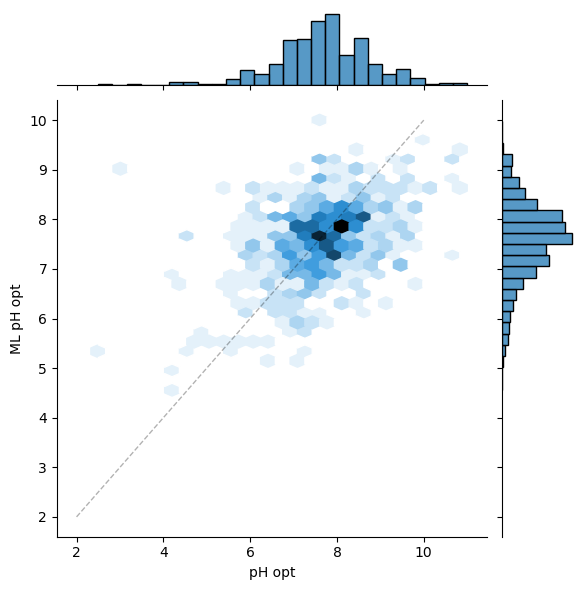

In [99]:
g = sns.jointplot(df_err, x="pH opt", y="ML pH opt", 
              # alpha=0.3, s=5, linewidth=0, 
                  kind="hex"
             )
g.ax_joint.plot([2,10], [2,10], ls='--', alpha=0.3, color="black", linewidth=1)

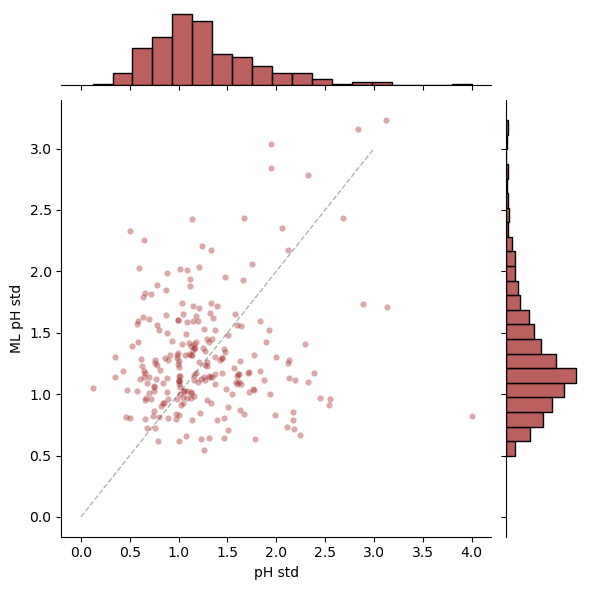

In [100]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              alpha=0.4, s=20, linewidth=0, 
                  # kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.3, color="black", linewidth=1)

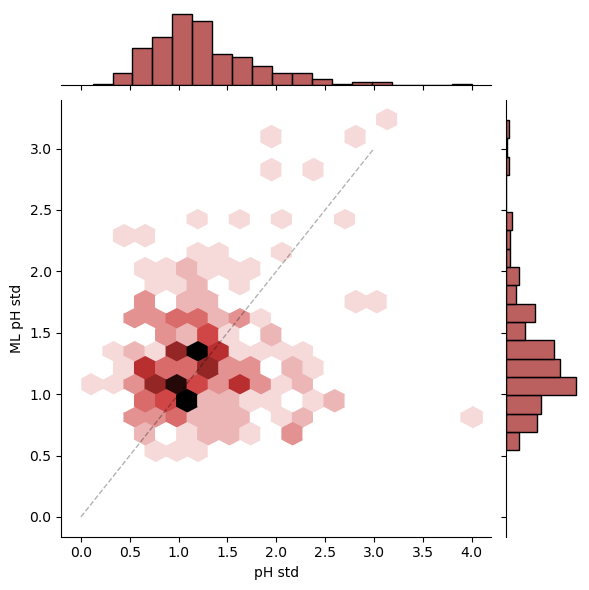

In [101]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              # alpha=0.4, s=20, linewidth=0, 
                  kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.3, color="black", linewidth=1)

In [103]:
len(df_err)

558

In [104]:
df_err

,pH opt,pH std,ML pH opt,ML pH std
0,5.500000,NaN,7.573602,1.191083
1,7.250000,NaN,7.897350,0.819812
2,7.500000,NaN,7.879851,1.160311
3,7.600000,NaN,5.866752,0.703047
4,7.000000,NaN,7.990245,1.707971
...,...,...,...,...
553,7.905451,0.874271,7.785497,1.847724
554,7.771832,1.664941,6.857756,0.835491
555,8.841219,1.462182,7.070836,0.646042
556,7.062500,NaN,5.815723,1.102091


In [105]:
len(df_err.dropna())

236